# Fontanka: fountain calling for a broad range of species

Fontanka was originally designed for fountain calling in zebrafish at 5.3 hpf (soon after ZGA), where other local Hi-C patterns like dots and stripes are not very pronounced. 

For other species and cell types, TADs and dots might be much more pronounced and significantly contaminate the fountain calling.

With appropriate strategy of filtration and thresholding, we can filter out non-fountain features of Hi-C maps. 

In this example, I focus on fountain calling around ZGA of _Xenopus tropicalis_ embryogenesis from Niu et al. 2021. 

Zygotic genome activation (ZGA) in happens around stage 8-9.
This, we will use the stage 11, which is later than ZGA, as an example of fountain calling. 

- Niu, Longjian, et al. "Three-dimensional folding dynamics of the Xenopus tropicalis genome." Nature Genetics 53.7 (2021): 1075-1087.

In [ ]:
# Pre-download the data: 
! mkdir -p data_xenopus/cool/

! wget https://osf.io/9qj27/download -O data_xenopus/WT.avfountain.npy # Average fountain based on manually called ones
! wget https://osf.io/vek84/download -O data_xenopus/cool/stage11.xenTro10.mapq_30.1000.mcool # Download Hi-C map

--2023-07-13 02:08:07--  https://osf.io/9qj27/download
Resolving osf.io (osf.io)... 35.190.84.173
Connecting to osf.io (osf.io)|35.190.84.173|:443... connected.
HTTP request sent, awaiting response... 302 FOUND
Location: https://files.osf.io/v1/resources/mt4vf/providers/osfstorage/64a84b44c3b67200e0d9085b?action=download&direct&version=1 [following]
--2023-07-13 02:08:07--  https://files.osf.io/v1/resources/mt4vf/providers/osfstorage/64a84b44c3b67200e0d9085b?action=download&direct&version=1
Resolving files.osf.io (files.osf.io)... 35.186.214.196
Connecting to files.osf.io (files.osf.io)|35.186.214.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13576 (13K) [application/octet-stream]
Saving to: ‘data_xenopus/WT.avfountain.npy’

data_xenopus/WT.avf 100%[===================>]  13.26K  --.-KB/s    in 0.001s  

2023-07-13 02:08:07 (18.9 MB/s) - ‘data_xenopus/WT.avfountain.npy’ saved [13576/13576]

--2023-07-13 02:08:08--  https://osf.io/vek84/download
Resolving

## 1. Prepare the genome

In [2]:
# obtain the chromosome lengths and positions of centromeres:
import bioframe
import cooler
import numpy as np

RESOLUTION = 10000
clr = cooler.Cooler(f"data_xenopus/cool/stage11.xenTro10.mapq_30.1000.mcool::/resolutions/{RESOLUTION}")

chromsizes = bioframe.fetch_chromsizes('xenTro10', as_bed=True).query("chrom not in ['chrM']")
chromsizes.loc[:, 'chrom'] = chromsizes.chrom.str.capitalize()
chromnames = [x for x in clr.chromnames if x in chromsizes.chrom.values]
cens = bioframe.fetch_centromeres('xenTro10')
arms = bioframe.make_chromarms(chromsizes, cens, cols_chroms=chromsizes.columns)
arms.start = arms.start.astype(int)
arms.end = arms.end.astype(int)
arms.loc[:, 'name'] = arms.apply(lambda x: f"{x.chrom}:{x.start}-{x.end}", axis=1)

# Sort chromosome arms based on the cooler input: 
arms = bioframe.sort_bedframe(arms, chromsizes.set_index('chrom').loc[chromnames, :].reset_index())

# Write the chromosome arms to the file (we need this to calculate appropriate expected per chromosome arm)
arms.to_csv("data_xenopus/xenTro10.arms.viewframe.tsv", sep="\t", header=None, index=None)

# Write genomic bins to the file:
bins = clr.bins()[:]
bins = bioframe.overlap(bins, arms, how="left", return_index=True).dropna(subset="start_").drop_duplicates('index').set_index('index') # Clean up those bins that do not fall into selected chromosome arms
bins = bins[['chrom', 'start', 'end', 'weight']]
bins.to_csv('./data_xenopus/xenTro10-reduced.bins.tsv', sep='\t', index=True)

In [3]:
# We will use the annotation of clean and bad bins in the genome later. 
# We define bad bins as those that were not corrected by iterative correction. 

offset = 5*RESOLUTION

bad_bins = bins.loc[np.isnan(bins.weight),:]
bad_bins = bioframe.expand(bad_bins, offset)
bad_bins = bioframe.trim(bad_bins, arms).dropna(subset='start')

clean_bins = bioframe.subtract(bins, bad_bins)[['chrom', 'start', 'end']]

## 2. Call fountains

We will assume that fountains in medaka have similar shape and size as the ones observed in zebrafish. 
Thus,. we will re-use the mask obtained for zebrafish reference. If you know that in your samples the fountains are very different in size and shape, it's better to create fountain mask from scratch as described in `00_fountanka_zebrafish.ipynb`. 

Be careful with data resolution, as the mask itself is not linked to any particular resolution, it's a square matrix of 41x41 size. 
This size corresponds to square window of 400 Kb centered around the expected fountain base, but only at 10 Kb resolution.

In [ ]:
%%bash 

### Set up the outpu directory: 
mkdir -p ./data_xenopus/expected/
mkdir -p ./data_xenopus/snips/
mkdir -p ./data_xenopus/fountains/

### Define the parameters:
NTHREADS=20
LABEL="stage11"
RESOLUTION=10000
FLANK=200000
LABEL_REF="WT"
MASK_PATH="./data_xenopus/${LABEL_REF}.avfountain.npy"

### Calculate expected:
cooltools expected-cis ./data_xenopus/cool/${LABEL}.xenTro10.mapq_30.1000.mcool::resolutions/${RESOLUTION} \
    --regions ./data_xenopus/xenTro10.arms.viewframe.tsv \
    -p $NTHREADS --clr-weight-name weight --ignore-diags 2 \
    -o ./data_xenopus/expected/${LABEL}.expected.tsv

### Snip the genome:
fontanka slice-windows ./data_xenopus/cool/${LABEL}.xenTro10.mapq_30.1000.mcool::resolutions/${RESOLUTION} \
    ./data_xenopus/snips/${LABEL}.200Kb.snips.npy \
    -p $NTHREADS -W ${FLANK} \
    --view ./data_xenopus/xenTro10.arms.viewframe.tsv --expected ./data_xenopus/expected/${LABEL}.expected.tsv

### Call the fountains: 
fontanka apply-fountain-mask ./data_xenopus/cool/${LABEL}.xenTro10.mapq_30.1000.mcool::resolutions/${RESOLUTION} \
        ./data_xenopus/fountains/${LABEL}.fontanka.200Kb.ref.output.tsv \
        --snips ./data_xenopus/snips/${LABEL}.200Kb.snips.npy \
        -W ${FLANK} -M ${MASK_PATH} \
        --view ./data_xenopus/xenTro10.arms.viewframe.tsv

## 3. Visualize and filter fontanka output

In [4]:
import pandas as pd

exp = "stage11"

# Read input table:
df_fountains = pd.read_table(f"./data_xenopus/fountains/{exp}.fontanka.200Kb.ref.output.tsv", index_col=0) # Output table with fountains called by zebrafish reference

# Take only measurements for chromosomal arms:
columns = df_fountains.columns
df_fountains = bioframe.overlap(df_fountains, arms).dropna(subset='start_').loc[:, columns]

# Clean up bad bins: 
is_bad = bioframe.overlap(df_fountains, clean_bins)['start_'].isna().values
df_fountains.loc[is_bad, ['FS', 'FS_peaks']] = np.nan

In [5]:
df_fountains.sort_values('FS', ascending=False).dropna().head()

,chrom,start,end,window_start,window_end,FS,FS_peaks,Scharr_box
107421,Chr7,49310000,49320000,49110000.0,49520000.0,0.750233,1.298089,39.032336
116974,Chr8,11270000,11280000,11070000.0,11480000.0,0.745573,1.228735,55.319520
1629,Chr1,16290000,16300000,16090000.0,16500000.0,0.745100,1.397025,23.616155
52947,Chr3,130950000,130960000,130750000.0,131160000.0,0.729548,1.300990,44.991654
113725,Chr7,112350000,112360000,112150000.0,112560000.0,0.722695,1.419226,41.555340


### 3.1. Threshold by peak prominence

In [6]:
# Apply thresholding to cut off huge peak in the distribution on the left: 
from skimage.filters import threshold_li

peak_prominence_th = threshold_li(df_fountains.FS_peaks.values)
print(peak_prominence_th)

0.17426942749135607


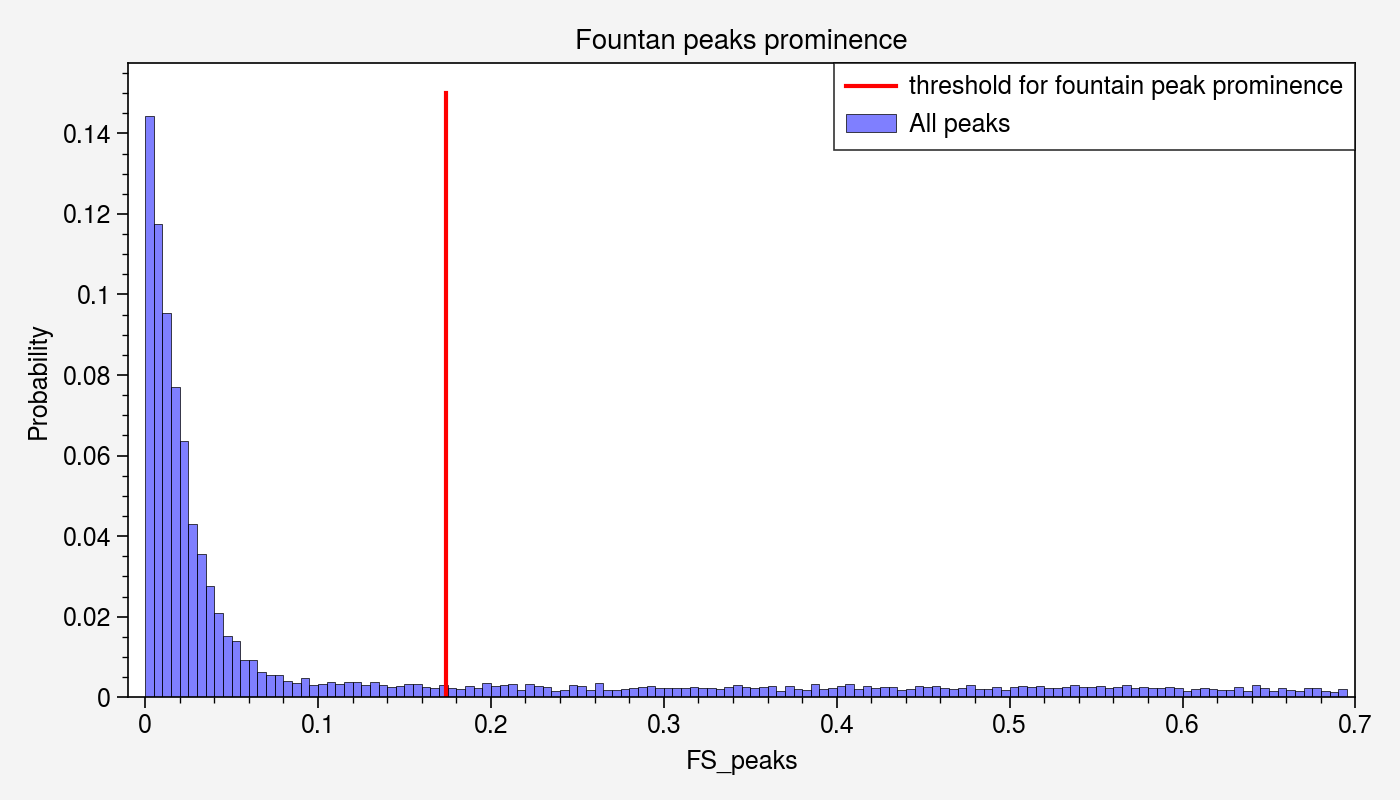

In [7]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import fontanka
import seaborn as sns

value = "FS_peaks"
title = "Fountan peaks prominence"

plt.figure(figsize=[7, 4])

sns.histplot(df_fountains.dropna(subset="FS_peaks")[value], 
             color='blue', alpha=0.5, stat='probability',
             bins=np.arange(-0.01, 0.7, 0.005), label='All peaks')

plt.plot([peak_prominence_th, peak_prominence_th], [0, 0.15], color='red', label='threshold for fountain peak prominence')

plt.xlim(-0.01, 0.7)

plt.title(title)
plt.legend()
plt.tight_layout()

In [8]:
df_fountains.loc[df_fountains['FS_peaks']<=peak_prominence_th, 'FS_peaks'] = np.nan

### 3.2 Threshold by noise score and fountain score

In [9]:
min_FS_ref = np.nanpercentile(df_fountains.FS, 90)
th_noise = np.nanpercentile(df_fountains.Scharr_box, 75)
df_strongest = df_fountains.query(f'FS>{min_FS_ref} and Scharr_box<{th_noise}').dropna(subset="FS_peaks")
df_strongest.sort_values('FS', ascending=False).dropna().head()

,chrom,start,end,window_start,window_end,FS,FS_peaks,Scharr_box
1629,Chr1,16290000,16300000,16090000.0,16500000.0,0.745100,1.397025,23.616155
111439,Chr7,89490000,89500000,89290000.0,89700000.0,0.715914,1.375147,32.371484
51971,Chr3,121190000,121200000,120990000.0,121400000.0,0.699276,1.173222,29.519746
142994,Chr10,33000000,33010000,32800000.0,33210000.0,0.686556,1.237140,25.236217
136734,Chr9,61620000,61630000,61420000.0,61830000.0,0.683417,1.284619,30.857986


In [10]:
len(df_strongest)

1733

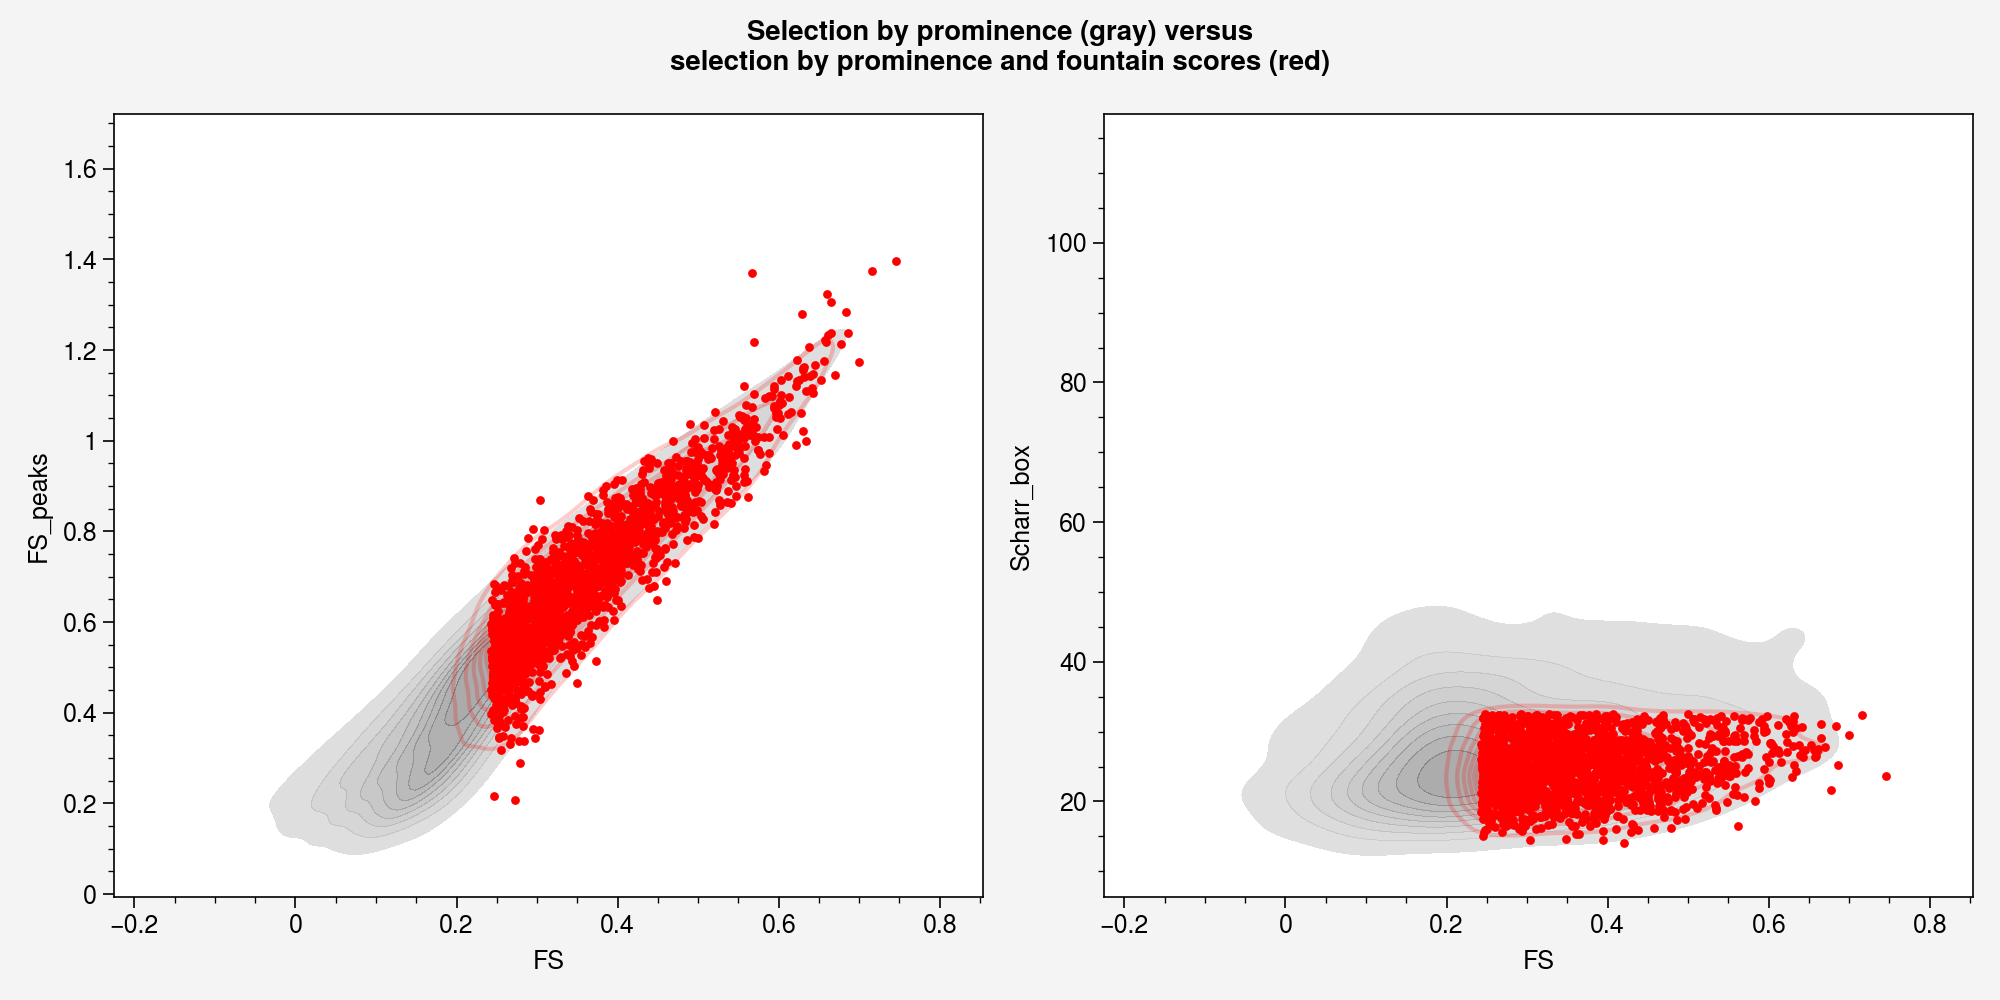

In [11]:
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=[10, 5])

ax = axes[0]
value_x = "FS"
value_y = "FS_peaks"

sns.kdeplot(    data=df_fountains.dropna(subset="FS_peaks"), x=value_x, y=value_y, color='black', alpha=0.5, fill=True, ax=ax)
sns.scatterplot(data=df_strongest, x=value_x, y=value_y, color='red', alpha=1, s=10, linewidth=0, ax=ax)
sns.kdeplot(    data=df_strongest, x=value_x, y=value_y, color='red', alpha=0.2, ax=ax)

ax = axes[1]
value_x = "FS"
value_y = "Scharr_box"

sns.kdeplot(    data=df_fountains.dropna(subset="FS_peaks"), x=value_x, y=value_y, color='black', alpha=0.5, fill=True, ax=ax)
sns.scatterplot(data=df_strongest, x=value_x, y=value_y, color='red', alpha=1, s=10, linewidth=0, ax=ax)
sns.kdeplot(    data=df_strongest, x=value_x, y=value_y, color='red', alpha=0.2, ax=ax)

fig.suptitle("Selection by prominence (gray) versus\nselection by prominence and fountain scores (red)")
plt.tight_layout()

Visualize the resulting fountain and noise scores: 

In [12]:
# Functions to help with plotting
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import cm
import cooltools
import cooltools.lib.plotting
import bioframe
plt.rcParams['font.size'] = 12

def pcolormesh_45deg(ax, matrix_c, start=0, resolution=1, *args, **kwargs):
    start_pos_vector = [start+resolution*i for i in range(len(matrix_c)+1)]
    import itertools
    n = matrix_c.shape[0]
    t = np.array([[1, 0.5], [-1, 0.5]])
    matrix_a = np.dot(np.array([(i[1], i[0])
                                for i in itertools.product(start_pos_vector[::-1],
                                                           start_pos_vector)]), t)
    x = matrix_a[:, 1].reshape(n + 1, n + 1)
    y = matrix_a[:, 0].reshape(n + 1, n + 1)
    im = ax.pcolormesh(x, y, np.flipud(matrix_c), *args, **kwargs)
    im.set_rasterized(True)
    return im

from matplotlib.ticker import EngFormatter
bp_formatter = EngFormatter('b')
def format_ticks(ax, x=True, y=True, rotate=True):
    if y:
        ax.yaxis.set_major_formatter(bp_formatter)
    if x:
        ax.xaxis.set_major_formatter(bp_formatter)
        ax.xaxis.tick_bottom()
    if rotate:
        ax.tick_params(axis='x',rotation=45)

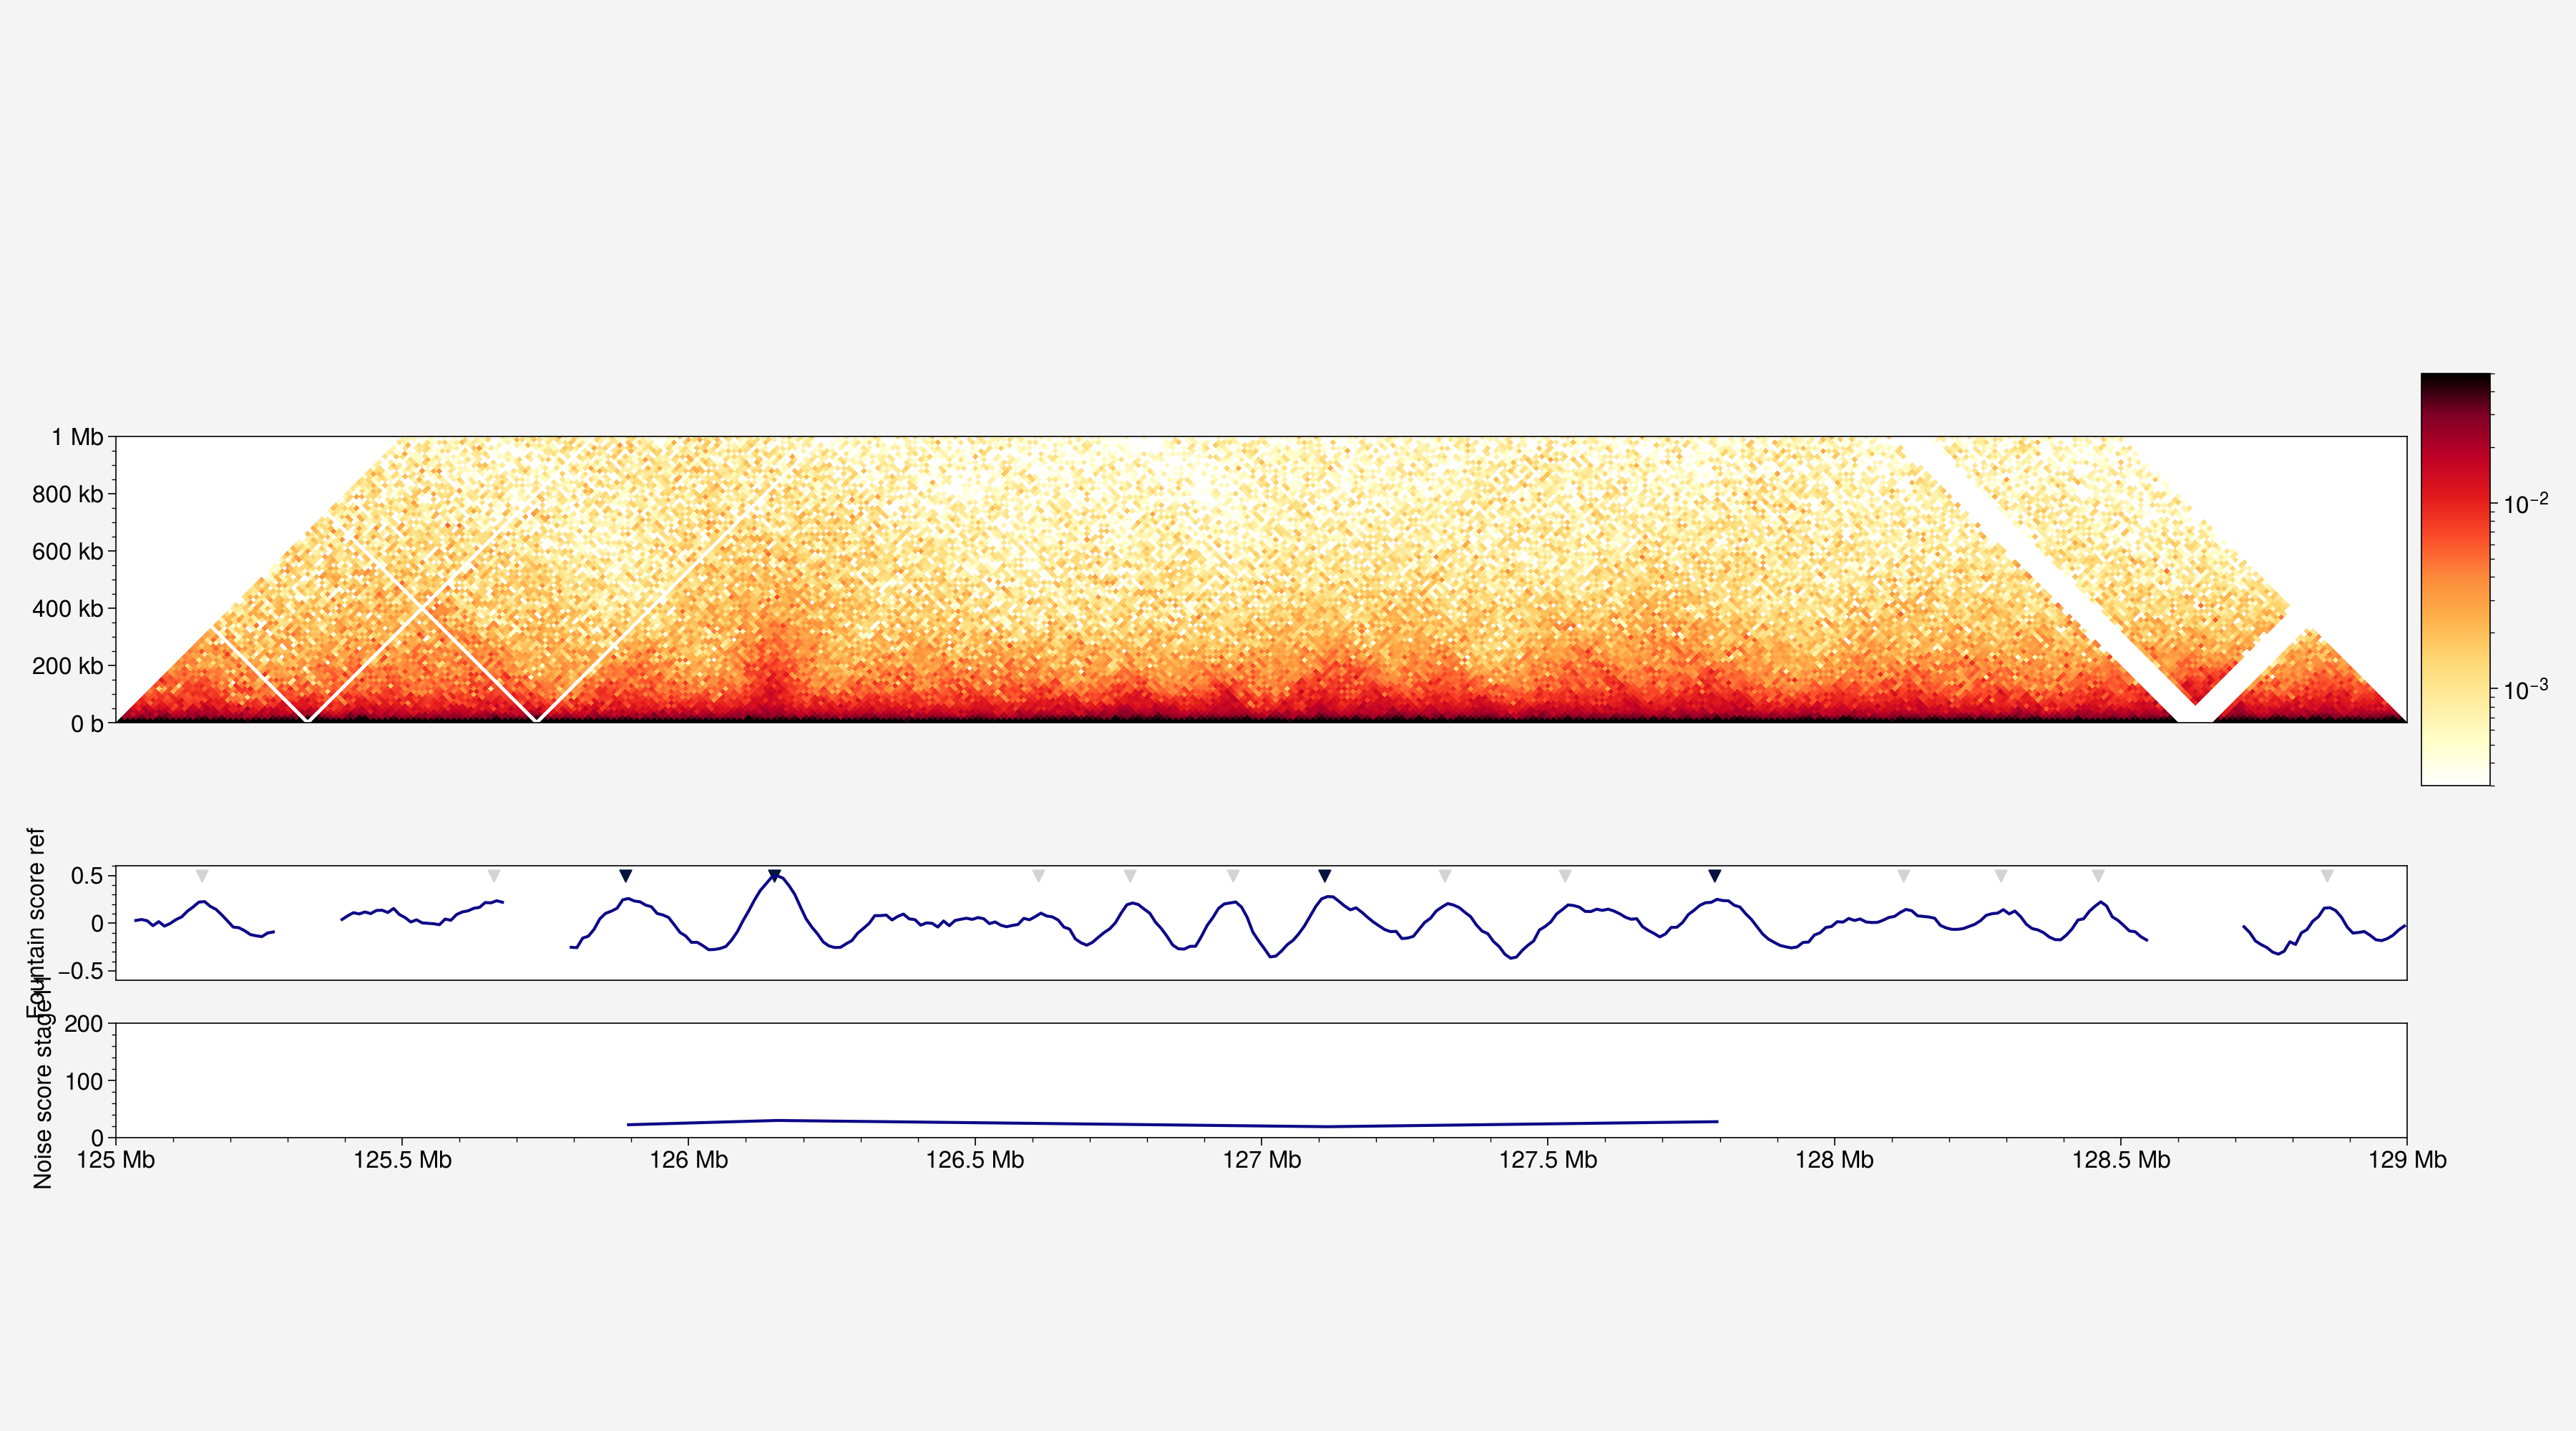

In [13]:
RESOLUTION = 10_000

start = 125_000_000
end = start + 400 * RESOLUTION
region = ('Chr1', start, end)

norm = LogNorm(vmax=0.05, vmin=0.0003)
cmap = 'fall'
data = clr.matrix(balance=True).fetch(region)

f, ax = plt.subplots(figsize=(18, 10))
im = pcolormesh_45deg(ax, data, start=region[1], resolution=RESOLUTION, norm=norm, cmap=cmap)
ax.set_aspect(0.5)
ax.set_ylim(0, 100*RESOLUTION)
format_ticks(ax, rotate=False)
ax.xaxis.set_visible(False)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.1, aspect=6)
plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax)


# Reference-based fountain score:
FS_region = bioframe.select(df_fountains, region)

FS_ax = divider.append_axes("bottom", size="20%", pad=0., sharex=ax)
FS_ax.set_prop_cycle(plt.cycler("color", plt.cm.plasma(np.linspace(0,1,5))))
FS_ax.plot(FS_region[['start', 'end']].mean(axis=1), 
    FS_region["FS"])
FS_ax.set_ylabel(f'Fountain score ref')
FS_ax.set_ylim(-0.6, 0.6)
FS_ax.xaxis.set_visible(False)

FS_region_peaks = FS_region.dropna(subset='FS_peaks')
for i, r in FS_region_peaks.iterrows():
    FS_ax.scatter(x=r.start, y=0.5, marker='v', color='lightgray', label="All peaks in fountain score")

# Strongest fountains
FS_region = bioframe.select(df_strongest, region)
FS_region_peaks = FS_region.dropna(subset='FS_peaks')
for i, r in FS_region_peaks.iterrows():
    FS_ax.scatter(x=r.start, y=0.5, marker='v', color='navy', label="Selected fountains")


# Noise score:
SS_ax = divider.append_axes("bottom", size="20%", pad=0.3, sharex=ax)
SS_ax.set_prop_cycle(plt.cycler("color", plt.cm.plasma(np.linspace(0,1,5))))
SS_ax.plot(FS_region[['start', 'end']].mean(axis=1), 
        FS_region[f'Scharr_box'])
SS_ax.set_ylabel(f'Noise score {exp}')
SS_ax.set_ylim(0, 200)
format_ticks(SS_ax, y=False, rotate=False)

ax.set_xlim(region[1], region[2])

f.tight_layout()

### Visualization of average fountains and fountain instances

In [14]:
exp = "stage11"
stack = np.load(f'./data_xenopus/snips/{exp}.200Kb.snips.npy')

In [15]:
stack.shape

(41, 41, 145233)

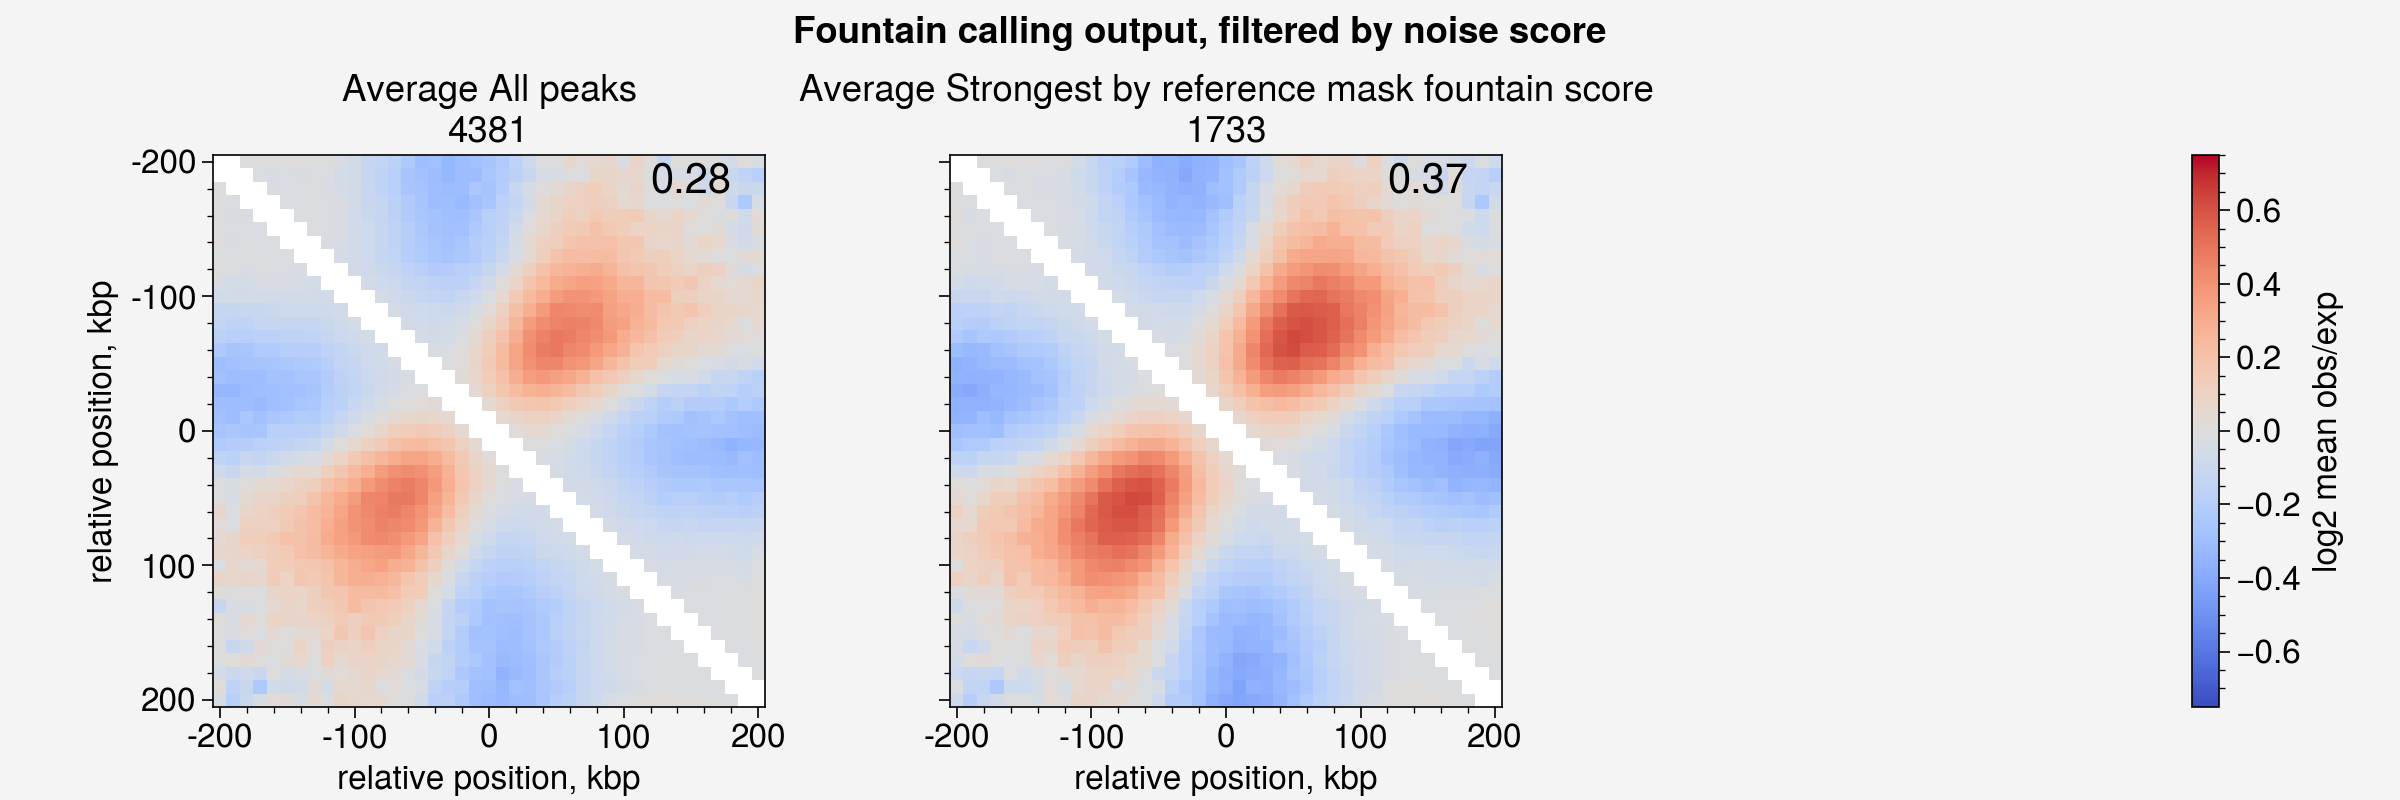

In [16]:
# Plot average patterns: 
FLANK = 200_000

fig, axes = plt.subplots(1, 3, figsize=[12, 4], sharey=True, sharex=True)
axes.flatten()[-1].set_axis_off()

for i, (df, title) in enumerate([
    (df_fountains.dropna(subset="FS_peaks"), "All peaks"),
    (df_strongest, "Strongest by reference mask fountain score"),
                 ]):
    
    bins_fountains = bioframe.overlap(bins, df, how='left', return_index=True).dropna(subset=["chrom_"]).set_index('index')
    index_fountains = list(bins_fountains.index.values)

    # Visualize fountain average: 
    pile = np.nanmean( stack[:, :, index_fountains], axis=2)
    pile = fontanka.reflect(pile)

    ax = axes.flatten()[i]
    im = ax.imshow(
        np.log2( pile ),
        vmax =  0.75,
        vmin = -0.75,
        cmap='coolwarm',
        interpolation=None)

    ticks_pixels = np.linspace(0, FLANK*2//RESOLUTION,5)
    ticks_kbp = ((ticks_pixels-ticks_pixels[-1]/2)*RESOLUTION//1000).astype(int)
    ax.set_xticks(ticks_pixels)
    ax.set_xticklabels(ticks_kbp)
    ax.set_xlabel('relative position, kbp')

    if i==0:
        ax.set_yticks(ticks_pixels)
        ax.set_yticklabels(ticks_kbp)
        ax.set_ylabel('relative position, kbp')

    score = np.nanmean(df_fountains.loc[index_fountains, 'FS'])
    ax.text(32.0, 0.0, f"{score:.2f}", 
        horizontalalignment='left', 
        verticalalignment='top', 
        fontsize=15)
    
    ax.set_title(f"Average {title}\n{len(index_fountains)}");
    
plt.colorbar(im, ax=axes.flatten()[-1], label = 'log2 mean obs/exp')
plt.suptitle("Fountain calling output, filtered by noise score")
plt.tight_layout()

In [17]:
# Examples of fountains:
df = df_strongest.copy()

bins_fountains = bioframe.overlap(bins, df, how='left', return_index=True).dropna(subset=["chrom_"]).set_index('index')
index_fountains = list(bins_fountains.sort_values('FS_', ascending=False).index.values)
    
idx_selected = index_fountains[:100]
nrows = len(idx_selected)//10 # n_samples_show
ncols = 10

fig, axes = plt.subplots(nrows, ncols, figsize=[4*ncols, 4*nrows])

for i, idx in enumerate(idx_selected):
    
    ax = axes.flatten()[i]
    
    mtx = stack[:, :, idx]
    mtx = fontanka.reflect(mtx)

    img = ax.matshow(
        np.log2(mtx),  
        vmin=-1.75,
        vmax=1.75,
        cmap='coolwarm',
        interpolation=None
    );
    ax.xaxis.tick_bottom()
    if i > 0:
        ax.yaxis.set_visible(False)

    ax.xaxis.set_visible(False)
    
    ax.minorticks_off()
    reg = bins.loc[idx, ['chrom', 'start', 'end']]
    ax.set_title(f"{idx}\n{reg.chrom}:{reg.start}-{reg.end}");
    
    ticks_pixels = np.linspace(0, FLANK*2//RESOLUTION,5)
    ticks_kbp = ((ticks_pixels-ticks_pixels[-1]/2)*RESOLUTION//1000).astype(int)
    plt.xticks(ticks_pixels, ticks_kbp)
    plt.yticks(ticks_pixels, ticks_kbp)
    plt.xlabel('relative position, kbp')
    plt.ylabel('relative position, kbp')
    
plt.show();